In [3]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import numpy as np
import os
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.framework.formats import landmark_pb2
from mediapipe import solutions
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load Data (NPY)

In [4]:
# test_variable = np.load("train_augmented/A_npy/aug_0_1165.npy")
# print(test_variable.shape)
# print(test_variable)

In [5]:
def muat_data_dan_label(folder_utama):
    data_label_list = []  # Variabel untuk menyimpan data dan label

    # Iterasi melalui subfolder
    for subfolder in os.listdir(folder_utama):
        if subfolder.endswith("_npy"):
            path_subfolder = os.path.join(folder_utama, subfolder)
            label = subfolder.replace("_npy", "")  # Menghapus "_npy" dari nama subfolder

            # Iterasi melalui setiap file .npy di subfolder
            for file in os.listdir(path_subfolder):
                if file.endswith(".npy"):
                    file_path = os.path.join(path_subfolder, file)
                    data = np.load(file_path)  # Memuat file .npy
                    # Menambahkan data dan label ke dalam tuple
                    data_label_list.append((data, label))
    
    return data_label_list

In [6]:
base_path = os.path.join(os.getcwd(), 'data_tambahan')
dataset = muat_data_dan_label(base_path)

In [7]:
def preprocess_data(data_label_list):
    data = []
    labels = []
    label_mapping = {}  # Untuk memetakan label unik ke indeks

    for i, (feature, label) in enumerate(data_label_list):
        if label not in label_mapping:
            label_mapping[label] = len(label_mapping)  # Berikan indeks baru untuk label baru
        data.append(feature)
        labels.append(label_mapping[label])

    # Konversi ke numpy array
    data = np.array(data)
    labels = np.array(labels)
    return data, labels, label_mapping


In [8]:
data, labels, label_mapping = preprocess_data(dataset)


In [9]:
print(label_mapping)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


# Membangun Model

In [10]:
data_train, data_val, labels_train, labels_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# Membuat dataset TensorFlow untuk training
train_dataset = tf.data.Dataset.from_tensor_slices((data_train, labels_train))
train_dataset = train_dataset.shuffle(buffer_size=100).batch(32)

# Membuat dataset TensorFlow untuk validation
val_dataset = tf.data.Dataset.from_tensor_slices((data_val, labels_val))
val_dataset = val_dataset.batch(32)

# Anda bisa menggunakannya untuk pelatihan model
# Misalnya, menggunakan model.fit() dengan dataset
# model.fit(train_dataset, validation_data=val_dataset, epochs=10)


In [11]:
data[0].shape

(126,)

In [12]:

# Membangun model sederhana dengan TensorFlow
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=data[0].shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_mapping), activation='softmax')
])


#Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 126)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          65,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,442 (939.23 KB)

 Trainable params: 240,442 (939.23 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = 300, verbose = 1)

Epoch 1/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1291 - loss: 2.9444 - val_accuracy: 0.4753 - val_loss: 1.4562
Epoch 2/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5772 - loss: 1.1892 - val_accuracy: 0.7433 - val_loss: 0.7690
Epoch 3/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7581 - loss: 0.7157 - val_accuracy: 0.8479 - val_loss: 0.4193
Epoch 4/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8577 - loss: 0.4399 - val_accuracy: 0.9068 - val_loss: 0.2664
Epoch 5/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9104 - loss: 0.2680 - val_accuracy: 0.9772 - val_loss: 0.1242
Epoch 6/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9598 - loss: 0.1449 - val_accuracy: 0.9867 - val_loss: 0.1023
Epoch 7/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9631 - loss: 0.1371 - val_accuracy: 0.9297 - val_loss: 0.2126
Epoch 8/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9503 - loss: 0.1371 - val_accuracy: 0.9791 - v

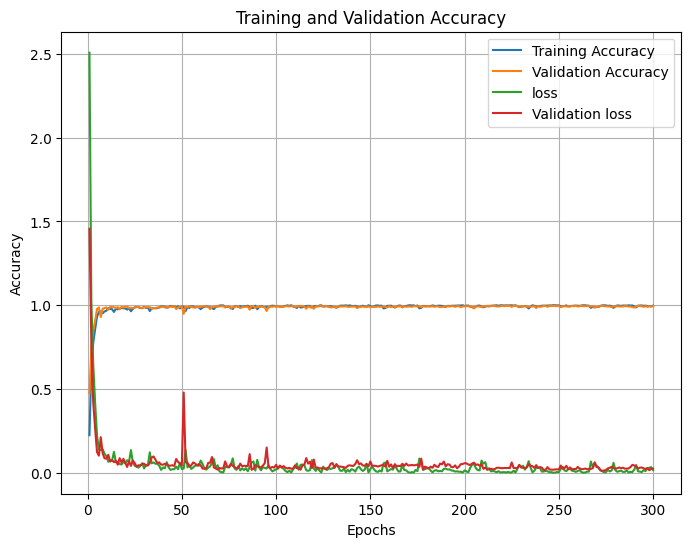

In [17]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = 301

# Membuat grafik akurasi
plt.figure(figsize=(8, 6))
plt.plot(range(1, epoch), train_acc, label='Training Accuracy')
plt.plot(range(1, epoch), val_acc, label='Validation Accuracy')
plt.plot(range(1, epoch), loss, label='loss')
plt.plot(range(1, epoch), val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Data uji tunggal
single_test_data = np.load('.npy')
single_test_data = np.expand_dims(single_test_data, axis=0)  # Ubah ke batch format

# Prediksi
prediksi = model.predict(single_test_data)
predicted_class = np.argmax(prediksi, axis=1)
print(f"Kelas prediksi untuk data tunggal: {predicted_class}")

In [18]:
model.save(filepath = 'model8.keras')
model.save(filepath = 'model8.h5')